## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

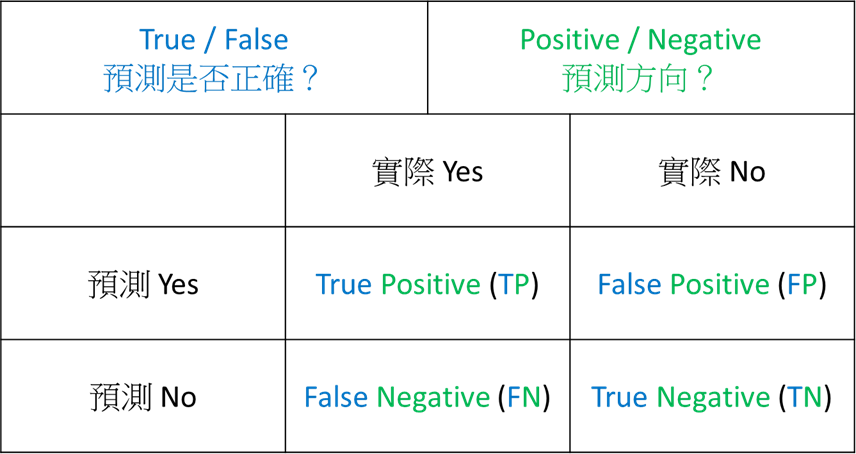

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    #初始化變數值 self.validation_data
    def __init__(self, valid_data=(x_test, y_test)):
        self.validation_data = valid_data
        
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        
        # 加入監控的衡量指標
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            try:
                if i not in self.params['metrics']:
                    self.params['metrics'].append(i)
            except:
                self.params['metrics'] = i
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        # 語法 .argmax(axis = -1) : 將onhot encoding轉回label
        y_true = self.validation_data[1].argmax(axis = -1)
        print(y_true)
        #print(y_true.shape)
        # .argmax(axis = -1) : 將predict的"各分類機率"的onhot encoding轉回label
        y_pred = self.model.predict(self.validation_data[0]).argmax(axis = -1)
        print(y_pred)
        print(y_pred.shape)
        #y_pred = (y_pred[:, 1] >= thres) * 1
        
        
        #加入的衡量指標的計算方式
        cm_tn, cm_fp, cm_fn, cm_tp = 0, 0, 0, 0
        print(multilabel_confusion_matrix(y_true, y_pred))
        #為三維陣列shape = (10,2,2) : 共 10筆 [2*2] 陣列 [[tn,fp], [fn,tp]]
        #print(multilabel_confusion_matrix(y_true, y_pred).shape)
        cm = multilabel_confusion_matrix(y_true, y_pred)
        num_classes = cm.shape[0]
        print ("numclasses: ", num_classes)
        #計算各個分類的平均數:
        for i in range(num_classes):
            cm_tn += cm[i,0,0]
            cm_fp += cm[i,0,1]
            cm_fn += cm[i,1,0]
            cm_tp += cm[i,1,1]
            
        cm_tn /= num_classes
        cm_fp /= num_classes
        cm_fn /= num_classes
        cm_tp /= num_classes
        
        logs["val_tp"] = cm_tp
        logs["val_tn"] = cm_tn
        logs["val_fp"] = cm_fp
        logs["val_fn"] = cm_fn
               
        #二元分類使用
        #logs["val_tp"] = confusion_matrix(y_true, y_pred)[1,1]
        #logs["val_tn"] = confusion_matrix(y_true, y_pred)[0,0]
        
#         val_tp = sum(y_true * y_pred)
#         val_tn = sum((y_true == 0) & (y_pred == 0))
#         logs["val_tp"] = val_tp
#         logs["val_tn"] = val_tn
        
rec_tptn = Record_tp_tn()

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp =  model.history.history['val_tp'] 
valid_tn =  model.history.history['val_tn']

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896 

Epoch 11/25
47/49 [===========================>..] - ETA: 0s - loss: 1.2806 - accuracy: 0.5567[3 8 8 ... 5 1 7]
[3 8 8 ... 3 5 4]
(10000,)
[[[8716  284]
  [ 547  453]]

 [[8673  327]
  [ 473  527]]

 [[8566  434]
  [ 710  290]]

 [[8415  585]
  [ 742  258]]

 [[8053  947]
  [ 508  492]]

 [[8275  725]
  [ 572  428]]

 [[8372  628]
  [ 448  552]]

 [[8752  248]
  [ 592  408]]

 [[8334  666]
  [ 304  696]]

 [[8488  512]
  [ 460  540]]]
numclasses:  10
49/49 [==============================] - 2s 34ms/step - loss: 1.2808 - accuracy: 0.5566 - val_loss: 1.5004 - val_accuracy: 0.4644 - val_tp: 464.4000 - val_tn: 8464.4000 - val_fp: 535.6000 - val_fn: 535.6000
Epoch 12/25
49/49 [==============================] - ETA: 0s - loss: 1.2539 - accuracy: 0.5671[3 8 8 ... 5 1 7]
[3 9 8 ... 5 5 7]
(10000,)
[[[8708  292]
  [ 538  462]]

 [[8642  358]
  [ 443  557]]

 [[8346  654]
  [ 626  374]]

 [[8277  723]
  [ 680  320]]

 [[8278  722]
  [ 563  437]]

 [[8444  556]
  [ 635  365]]

 [[8384  616]
  [ 4

Epoch 24/25
48/49 [============================>.] - ETA: 0s - loss: 0.9835 - accuracy: 0.6689[3 8 8 ... 5 1 7]
[3 8 0 ... 3 5 7]
(10000,)
[[[8522  478]
  [ 416  584]]

 [[8596  404]
  [ 429  571]]

 [[8347  653]
  [ 600  400]]

 [[8230  770]
  [ 657  343]]

 [[8470  530]
  [ 591  409]]

 [[8501  499]
  [ 634  366]]

 [[8609  391]
  [ 498  502]]

 [[8568  432]
  [ 455  545]]

 [[8512  488]
  [ 348  652]]

 [[8534  466]
  [ 483  517]]]
numclasses:  10
49/49 [==============================] - 2s 40ms/step - loss: 0.9836 - accuracy: 0.6689 - val_loss: 1.4662 - val_accuracy: 0.4889 - val_tp: 488.9000 - val_tn: 8488.9000 - val_fp: 511.1000 - val_fn: 511.1000
Epoch 25/25
49/49 [==============================] - ETA: 0s - loss: 0.9619 - accuracy: 0.6768[3 8 8 ... 5 1 7]
[3 8 8 ... 3 5 7]
(10000,)
[[[8654  346]
  [ 470  530]]

 [[8551  449]
  [ 388  612]]

 [[8576  424]
  [ 689  311]]

 [[8253  747]
  [ 657  343]]

 [[8382  618]
  [ 551  449]]

 [[8414  586]
  [ 605  395]]

 [[8562  438]
  [ 4

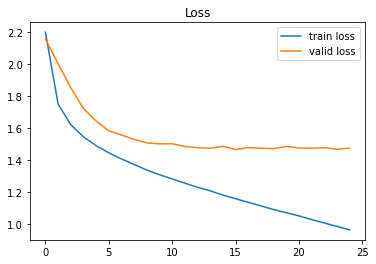

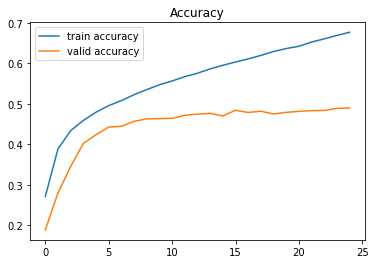

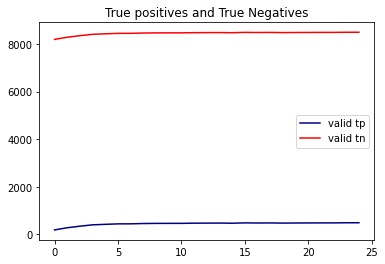

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
